# Spaceship Titanic
Submission by *Rick Arendsen*

After attempting the regular titanic exercise I thought it might be a good idea to try and tackle this one.

In [1]:
# Import our required libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow  as tf

# Import TensorFlow Dependencies:
from tensorflow import keras
from tensorflow.keras.layers import Normalization, Dropout, GaussianNoise, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Import Model Training Dependencies:
from sklearn.model_selection import train_test_split

2025-10-02 11:56:51.760764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759406211.971129      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759406212.032128      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIRECTORY: str = "/kaggle/input/spaceship-titanic"
TRAIN_PATH = f"{BASE_DIRECTORY}/train.csv"
TEST_PATH = f"{BASE_DIRECTORY}/test.csv"

# Load the file we'll be using.
data = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

## Data Analysis
Let's start by seeing what the data looks like, and let's try finding the correlations between each attribute.

In [3]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


It looks like we've got some non-numeric values.
**Let's start by mapping these,** so that we can use them within correlations and *(perhaps)* include them in the final features.

In [4]:
def preprocess_df(df):
    df = df.copy()

    df['HomePlanet'] = df['HomePlanet'].fillna("Unknown").astype(str)
    df['Cabin'] = df['Cabin'].fillna("Unknown").astype(str)
    df['Destination'] = df['Destination'].fillna("Unknown").astype(str)

    # split Cabin
    cabin_split = df["Cabin"].str.split("/", expand=True)
    df["Deck"] = cabin_split[0].fillna("Unknown")
    df["CabinNum"] = pd.to_numeric(cabin_split[1], errors="coerce").fillna(0)
    df["Side"] = cabin_split[2].fillna("Unknown")

    # cast dtypes
    df["HomePlanet"] = df["HomePlanet"].astype(str)
    df["Destination"] = df["Destination"].astype(str)
    df["Deck"] = df["Deck"].astype(str)
    df["Side"] = df["Side"].astype(str)
    df["CabinNum"] = df["CabinNum"].astype("float32")
    
    return df

data = preprocess_df(data)

Now that we've cleaned the data, let's take a look at the data correlations!

<Axes: >

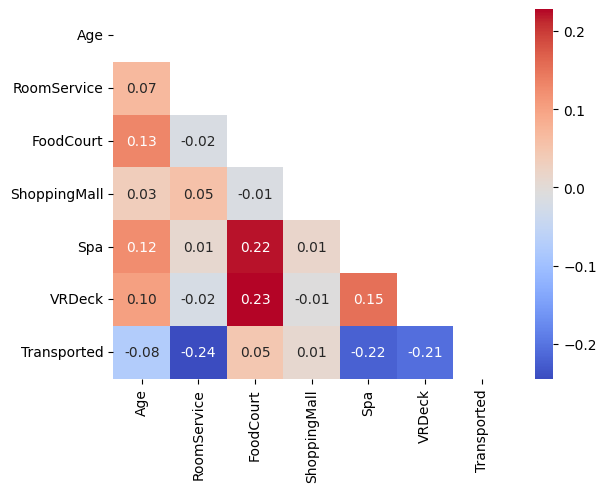

In [5]:
numeric_df = data.select_dtypes(include=['int64', 'float64', 'bool'])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm")

In [6]:
# Create Layers:
homeplanet_layer = tf.keras.layers.StringLookup(output_mode="one_hot", mask_token=None)
cabin_layer = tf.keras.layers.StringLookup(output_mode="one_hot", mask_token=None)
destination_layer = tf.keras.layers.StringLookup(output_mode="one_hot", mask_token=None)

deck_layer = tf.keras.layers.StringLookup(output_mode="one_hot", mask_token=None)
cabin_side_layer = tf.keras.layers.StringLookup(output_mode="one_hot", mask_token=None)

# Adapt Layers:
homeplanet_layer.adapt(data['HomePlanet'])
cabin_layer.adapt(data['Cabin'])
destination_layer.adapt(data['Destination'])

deck_layer.adapt(data['Deck'])
cabin_side_layer.adapt(data['Side'])

# Cabin Number is interpreted as an integrer, so normalize and adapt a numeric layer:
cabin_num_layer = tf.keras.layers.Normalization()
cabin_num_layer.adapt(np.array(data['CabinNum']).reshape(-1, 1))

I0000 00:00:1759406225.662574      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759406225.663286      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Now that we've gotten our layers, let's plug it into the model.

In [7]:
from tensorflow.keras import layers, Model

inputs = {
    "HomePlanet": layers.Input(shape=(1,), dtype=tf.string, name="HomePlanet"),
    "Destination": layers.Input(shape=(1,), dtype=tf.string, name="Destination"),
    "Deck": layers.Input(shape=(1,), dtype=tf.string, name="Deck"),
    "Side": layers.Input(shape=(1,), dtype=tf.string, name="Side"),
    "CabinNum": layers.Input(shape=(1,), dtype=tf.float32, name="CabinNum"),
}

# Encode categorical features
homeplanet_encoded = homeplanet_layer(inputs["HomePlanet"])
destination_encoded = destination_layer(inputs["Destination"])
deck_encoded = deck_layer(inputs["Deck"])
side_encoded = cabin_side_layer(inputs["Side"])

# Normalize numeric feature
cabin_num_encoded = cabin_num_layer(inputs["CabinNum"])

Now that we've encoded the layers, transform it into a vector.

In [8]:
x = layers.concatenate([
    homeplanet_encoded,
    destination_encoded,
    deck_encoded,
    side_encoded,
    cabin_num_encoded
])

In [9]:
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x) 

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [10]:
X = data.drop(columns=["Transported"])  
y = data["Transported"].astype(int) 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Cast the features into the correct types:
def cast_features(df):
    df = df.copy()
    
    df["HomePlanet"] = df["HomePlanet"].astype(str)
    df["Destination"] = df["Destination"].astype(str)
    df["Deck"] = df["Deck"].astype(str)
    df["Side"] = df["Side"].astype(str)
    df["CabinNum"] = df["CabinNum"].astype("float32")
    
    return df

# Cast training data into right types:
X_train = cast_features(X_train)
X_val = cast_features(X_val)

In [11]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,  
    restore_best_weights=True
)

history = model.fit(
    {col: X_train[col].values for col in inputs.keys()},
    y_train.values,
    validation_data=(
        {col: X_val[col].values for col in inputs.keys()},
        y_val.values
    ),
    
    callbacks=[early_stop],
    epochs=35,
    batch_size=64
)

Epoch 1/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5666 - loss: 0.6823 - val_accuracy: 0.6265 - val_loss: 0.6546
Epoch 2/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6072 - loss: 0.6598 - val_accuracy: 0.6421 - val_loss: 0.6414
Epoch 3/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6300 - loss: 0.6525 - val_accuracy: 0.6509 - val_loss: 0.6354
Epoch 4/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6419 - loss: 0.6450 - val_accuracy: 0.6509 - val_loss: 0.6336
Epoch 5/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6475 - loss: 0.6385 - val_accuracy: 0.6559 - val_loss: 0.6324
Epoch 6/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6455 - loss: 0.6371 - val_accuracy: 0.6550 - val_loss: 0.6321
Epoch 7/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6467 - loss: 0.6381 - val_accuracy: 0.6596 - val_loss: 0.6306
Epoch 8/35
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6555 - loss: 0.6350 - val_accuracy: 0

In [12]:
# Cast test set to the correct format & typings:
test = preprocess_df(test)
test = cast_features(test)

predictions = (model.predict({col: test[col].values for col in inputs.keys()}) > 0.5).astype("int")

# Build submission:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Transported": predictions.ravel().astype(bool)
})

submission.to_csv("submission.csv", index=False)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
